# Plot multi-type trees from mascot analysis using baltic

March 13, 2020

I ran a whole series of permutations, similar to bdmm, but using mtt for the primary outbreak clade. I now want to plot the results. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib, Bio, datetime
from subprocess import call
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import seaborn as sns
%load_ext rpy2.ipython

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

import imp
bt = imp.load_source('baltic', '../../baltic/baltic/baltic.py')

In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300

In [3]:
def generate_tree_object(tree_path):

    # load mtt trees
    tree = bt.loadNexus(tree_path)
    
    # pull out the name of the tree file 
    filename = tree_path.replace(".mcc.tree","-community_member_tree.pdf")
    
    return(tree,filename)

In [4]:
def return_metadata_dictionaries(tree):
    # parse leaf and node information into a dictionary for plotting
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects: ## iterate over objects in tree
        if isinstance(k, bt.leaf) == True or k.branchType=='leaf':
            community_status = k.traits['max']
            vaccine_status = k.name.split("|")[7]
            #WA_county = k.name.split("|")[8]
            metadata[k] = {}
            metadata[k]["community_status"] = community_status
            metadata[k]["vaccine_status"] = vaccine_status
            #metadata[k]["WA_county"] = WA_county

        # parse the nodes now and pick out the type trait
        if isinstance(k, bt.node) == True or k.branchType=='node':
            node_community_status = k.traits["max"]
            node_types[k] = {}
            node_types[k]["node_community_status"] = node_community_status
            
            node_date = k.absoluteTime
            node_types[k]['date'] = node_date
            
            prob_node_Marshallese = k.traits["max.prob"]
            node_probs[k] = {}
            node_probs[k] = prob_node_Marshallese
            
            
    return(metadata, node_types, node_probs)

In [5]:
# read in files and run 
tree_path = "../beast/mascot/output/mumps_1.mcc.tree"
tree,filename = generate_tree_object(tree_path)
metadata,node_types,node_probs = return_metadata_dictionaries(tree)

In [6]:
filename = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/mascot-3-deme-tree-2020-09-15.pdf"

In [7]:
# more blues
Not_Marshallese_color = '#012E74'
Marshallese_color = '#80AAC9'
Outside_color = '#adadad'

colors = {'Marshallese':Marshallese_color, 'Not_Marshallese':Not_Marshallese_color, 
          'Outside':Outside_color}

legend_order = ["Marshallese","Not_Marshallese", "Outside"]

labels = {'Marshallese':'Mashallese', 'Not_Marshallese':'Not Marshallese',
         'Outside': "Not Washington"}

In [8]:
dates_dict = {2015:{"label":"Jan\n2015", "date":"2015-01-01"}, 
             2015.25:{"label":"Apr\n2015", "date":"2015-04-01"},
             2015.5:{"label":"Jul\n2015", "date":"2015-07-01"},
             2015.75:{"label":"Oct\n2015", "date":"2015-10-01"},
             2016:{"label":"Jan\n2016", "date":"2016-01-01"}, 
             2016.25:{"label":"Apr\n2016", "date":"2016-04-01"},
             2016.5:{"label":"Jul\n2016", "date":"2016-07-01"},
             2016.75:{"label":"Oct\n2016", "date":"2016-10-01"},
             2017:{"label":"Jan\n2017", "date":"2017-01-01"}, 
             2017.25:{"label":"Apr\n2017", "date":"2017-04-01"},
             2017.5:{"label":"Jul\n2017", "date":"2017-07-01"},
             2017.75:{"label":"Oct\n2017", "date":"2017-10-01"}}

<baltic.node object at 0x12477cb00> <baltic.node object at 0x12477cbe0>


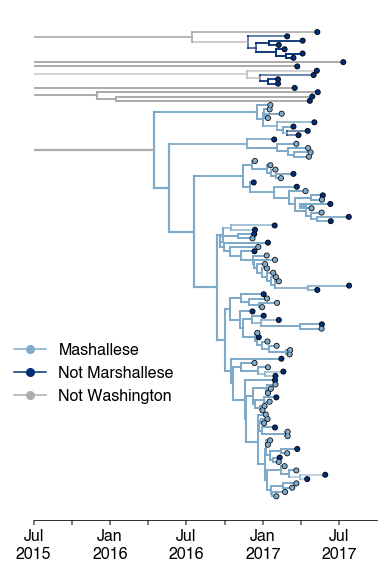

In [13]:
fig,ax = plt.subplots(figsize=(6,8),facecolor='w')

node_colors = clr.LinearSegmentedColormap.from_list('custom ', [Not_Marshallese_color,Marshallese_color], N=256)

# # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
min_date = 2015.5
dates_ls = []
for i in np.arange(min_date,2017.75,0.25):
    dates_ls.append(i) 
#[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

# set date labels to be every 4
date_labels = []
for d in dates_ls[::2]:
    date_labels.append(dates_dict[d]['label'])
    if d < 2018:
        date_labels.append("")

branchWidth=2 ## default branch width
tipSize = 20

# k objects are tips, nodes, branches
for k in tree.Objects: ## iterate over objects in tree
    x=k.absoluteTime ## or use absolute time instead
    y=k.y 
    
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x
    
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...        
        c=colors[metadata[k]["community_status"]]
        s=tipSize
        parent_color = colors[node_types[k.parent]["node_community_status"]]
        a=node_probs[k.parent]
        
        ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
        ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        number_children = len(k.leaves)
        node_branchwidth = branchWidth + number_children*0.0025
        c=colors[node_types[k]["node_community_status"]]
        #c=node_colors(node_probs[k])
        a=node_probs[k]
        
        # this is the vertical line connecting nodes; 
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,alpha=a,ls='-',zorder=9)
        
        # this is the horizontal line connecting internal nodes to other nodes, or tips to nodes 
        if k.parent:
            if k.parent in node_types:
                parent_color = colors[node_types[k.parent]["node_community_status"]]
            else:
                print(k, k.parent)
                parent_color = "red"
        else:
            parent_color = Outside_color
        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=parent_color,alpha=a,ls='-',zorder=9)
        
    # add in a legend
    han_list = []

    # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
for key in legend_order:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = labels[key], markersize = 8)
    han_list.append(marker)

# set axis limits, remove border lines         
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.set_ylim(-5,tree.ySpan+5)
ax.tick_params(axis='y',labelsize=0,size=0)
ax.tick_params(axis='x',labelsize=16,size=5, width=2,color='grey')
ax.set_xticks(dates_ls)
ax.set_xticklabels(date_labels)   # set date labels every 4
#ax.set_xlim(1993.8,2018.2)
ax.set_xlim(min_date,2017.75)
ax.set_yticklabels([])

# in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
# bbox arguments are: x, y, with 0 being furthest left and bottom
ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.1, 0.2], loc=3,prop={'size': 16}, facecolor='w')

fig.tight_layout()
plt.gcf().subplots_adjust(right=0.88)

plt.savefig(filename)

plt.show()

# Plot posterior probability node is community

In [9]:
node_probs_df = pd.DataFrame()

for k in node_probs:
    if k.branchType=='node':
        pp = node_probs[k]
        group = node_types[k]["node_community_status"]
        date = node_types[k]["date"]
        n = pd.DataFrame({'node':[k],'pp':[pp], 'group':[group], 'date':[date]})
        n.reset_index(inplace=True)
        n.columns = ['index','node','pp','group','date']
        node_probs_df = node_probs_df.append(n)

node_probs_df.head()

,index,node,pp,group,date
0,0,<baltic.node object at 0x7fe5ff474b38>,1.000000,Outside,1997.298595
0,0,<baltic.node object at 0x7fe5ff474d68>,1.000000,Outside,2001.332721
0,0,<baltic.node object at 0x7fe5ff474c18>,0.995885,Outside,2013.155145
0,0,<baltic.node object at 0x7fe5ff474ba8>,1.000000,Marshallese,2016.285397
0,0,<baltic.node object at 0x7fe5ff474c88>,1.000000,Marshallese,2016.385566


In [10]:
node_probs_outfile_name = "node_probs-mascot-2020-09-15.pdf"
outfile_directory = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/"

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "node". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'baltic.node'>'
  (name, str(e)))
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


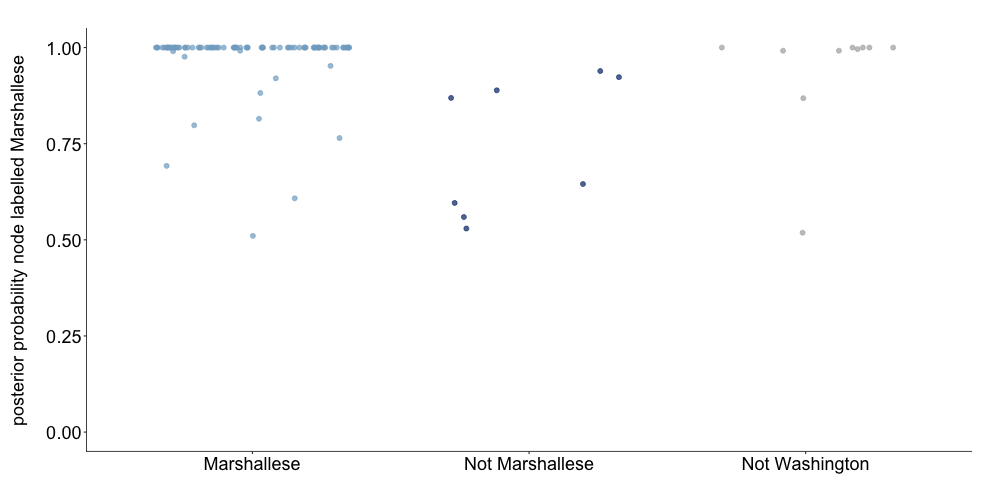

In [11]:
%%R -w 1000 -h 500 -u px -i node_probs_df,node_probs_outfile_name,outfile_directory,Marshallese_color,Not_Marshallese_color,Outside_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

node_probs_df$pp = as.numeric(node_probs_df$pp)

p8 <- ggplot(data=node_probs_df, aes(x=group, y=pp, color=group)) + 
    geom_jitter(size=2, alpha=0.7, position = position_jitter(w = 0.35, h = 0))+
    labs(x=NULL,y="posterior probability")+
    scale_color_manual(values=c("Marshallese"=Marshallese_color,"Not_Marshallese"=Not_Marshallese_color,"Outside"=Outside_color), guide=FALSE)+
    scale_x_discrete(labels=c("Marshallese","Not Marshallese","Not Washington"))+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=18))+
    theme(axis.title.y=element_text(size=18, vjust=8))+
    theme(axis.title.x=element_text(size=18, vjust=-6))+
    theme(axis.text=element_text(size=18, colour="black"))+
    theme(legend.text=element_text(size=18))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    #scale_x_continuous(expand = c(0, 0), breaks=seq(0,30,5), limits=c(-0.5,35)) + 
    scale_y_continuous(limits=c(0,1))

ggsave(node_probs_outfile_name, p8, width = 10, height = 3.5, path=outfile_directory)
p8

# Plot parameter estimates

In [57]:
def generate_dataframes_from_log_files(log_file):
    
    log = pd.read_table(log_file, sep='\t', header=0, comment='#')

    Ne_cols = [col for col in log.columns if 'Ne.' in col]
    mig_cols = [col for col in log.columns if 'b_migration' in col]
    
    # subset to just Ne, migration rates, or jump counts
    Ne = log[Ne_cols]
    mig_rates = log[mig_cols]
    
    # replace column names
    Ne.columns = Ne.columns.str.replace("Ne.Marshallese", "Marshallese")
    Ne.columns = Ne.columns.str.replace("Ne.Not_Marshallese", "Not Marshallese")
    Ne.columns = Ne.columns.str.replace("Ne.Outside", "Not Washington")
    
    # in these columns, b is for backwards in time
    mig_rates.columns = mig_rates.columns.str.replace("b_migration.Marshallese_to_Not_Marshallese", "Marshallese to Not Marshallese")
    mig_rates.columns = mig_rates.columns.str.replace("b_migration.Not_Marshallese_to_Marshallese", "Not Marshallese to Marshallese")
    mig_rates.columns = mig_rates.columns.str.replace("b_migration.Marshallese_to_Outside", "Marshallese to Not Washington")
    mig_rates.columns = mig_rates.columns.str.replace("b_migration.Not_Marshallese_to_Outside", "Not sMarshallese to Not Washington")

    # melt and split out clade name and type of transition/deme
    mig_rates = pd.melt(mig_rates)
    Ne = pd.melt(Ne)

    return(Ne,mig_rates)

In [58]:
def create_outfile_names():
    date = (datetime.datetime.now()).strftime('%Y-%m-%d')
    
    Ne_outfile_name = "Ne-mtt-" + date + ".pdf"
    mig_outfile_name = "migration-rates-mtt-"+ date + ".pdf"
    
    return(Ne_outfile_name,mig_outfile_name)

In [59]:
def run_functions(input_file):
    

    # generate output file names 
    Ne_outfile_name,mig_outfile_name = create_outfile_names()

    # generate dataframes and append together
    Ne_all = pd.DataFrame()
    mig_all = pd.DataFrame()

    Ne,mig_rates = generate_dataframes_from_log_files(input_file)

    Ne_all = Ne_all.append(Ne)
    mig_all = mig_all.append(mig_rates)

    return(Ne_all,mig_all,Ne_outfile_name,mig_outfile_name)

In [82]:
def return_hpdi(input_df):
    
    hpdi_df = pd.DataFrame()
    updated_dataframe = pd.DataFrame()
    
    # for each category, split into its own dataframe
    for t in set(input_df['variable'].tolist()):
        d = input_df[input_df['variable'] == t]
        
        # compute highest posterior density interval
        import pymc3
        from scipy.stats import norm
        hpdi = pymc3.stats.hpd(d['value'], credible_interval=0.95)
        lower = hpdi[0]
        upper = hpdi[1]
        
        hpdi_df = hpdi_df.append(pd.DataFrame.from_dict({"variable":[t],"lower":[lower],"upper":[upper]}))
        
        # add a new column to the dataframe to specify whether a value is in the 95% HPDI or not 
        d['hpdi'] = np.where((d['value'] >= lower) & (d['value'] <= upper), "yes","no")
        updated_dataframe = updated_dataframe.append(d)
    
    return(hpdi_df,updated_dataframe)

In [60]:
# run on the combined log file output from Log Combiner 
combined_log_file = "../beast/mascot/output/mumps_1.log"
Ne,mig,Ne_outfile_name,mig_outfile_name = run_functions(combined_log_file)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
Ne.head()

,variable,value
0,Marshallese,0.689299
1,Marshallese,0.410189
2,Marshallese,0.714529
3,Marshallese,0.413610
4,Marshallese,0.234718


In [86]:
HPDI_df_Ne,Ne = return_hpdi(Ne)

HPDI_df_Ne
Ne.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,variable,value,hpdi
0,Marshallese,0.689299,yes
1,Marshallese,0.410189,yes
2,Marshallese,0.714529,yes
3,Marshallese,0.413610,yes
4,Marshallese,0.234718,no


In [ ]:
date = (datetime.datetime.now()).strftime('%Y-%m-%d')
outfile_directory = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/individual-PDFs/"

In [ ]:
Ne_outfile_name = "Ne-mascot-ghost-deme-"+date+".pdf"

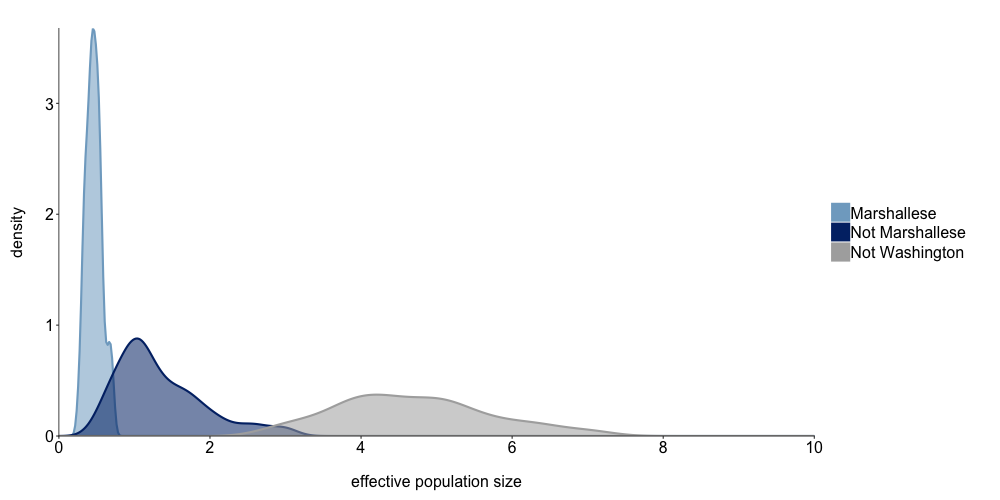

In [88]:
%%R -w 1000 -h 500 -u px -i Ne,Ne_outfile_name,Marshallese_color,Not_Marshallese_color,Outside_color  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

hpdi_only <- Ne[Ne$hpdi == 'yes',]

p6 <- ggplot(data=hpdi_only, aes(x=value, group=variable, color=variable, fill=variable, alpha=0.8)) + 
    geom_density(data=hpdi_only, aes(x=value,group=variable, color=variable, fill=variable),linetype="solid",size=1)+
    labs(x="effective population size",y="density")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_color_manual(values=c(Marshallese_color, Not_Marshallese_color,Outside_color), labels=c("Marshallese","Not Marshallese","Not Washington"))+
    scale_fill_manual(values=c(Marshallese_color, Not_Marshallese_color,Outside_color), labels=c("Marshallese","Not Marshallese","Not Washington"))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=16))+
    theme(axis.title.y=element_text(size=16, vjust=8))+
    theme(axis.title.x=element_text(size=16, vjust=-6))+
    theme(axis.text=element_text(size=16, colour="black"))+
    theme(axis.text.x=element_text(size=16))+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,1,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))+
    scale_alpha(guide = 'none')+
    scale_x_continuous(expand = c(0, 0), limits=c(0,10), breaks=seq(0,10,2)) + 
    scale_y_continuous(expand = c(0, 0))

ggsave(Ne_outfile_name, p6, width = 8, height = 4, path=outfile_directory)
p6